# Day23 Airbnb in Berlin 4/5 listings analysis 
# 柏林Airbnb 4/5 蛋黃區房源分析

昨日(Day22)的文章中，先以低排放區郵遞區號篩選取出房源列表後排序，取房源數量最多的前十名(主要是柏林占地太大，Airbnb上劃分成了133個區，加上交通因素考量，僅取中間環狀輕軌電車內區域做分析)，儲存成ab_top10_listing.csv。由原先24395降至7380筆，數量依舊可觀。今天來稍微看一下昨日存的資料樣貌。<br>
In last article we used the postcode of the low-emission zone as a filter to get the listings within the S-Bahn ring zone. Then we sort and save only the listings with the top 10 amount as ab_top10_listing.csv. The listing went from 24395 to 7380, which is still a large amount of data. Today we will then walk through the data to have a look at it.

In [1]:
# 載入所需套件 import the packages we need
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py 

import warnings # 忽略警告訊息 
warnings.filterwarnings("ignore") 

# 讀入檔案來分析 
Read in the file

In [2]:
toplist = pd.read_csv('ab_top10_listing.csv') # 讀入昨天存的檔案來分析 read in the file we created yesterday
print('There are', toplist.id.nunique(), 'listings in the listing data.')
toplist.info() # 查看資料細節 the info of data
toplist.head(3) # 叫出前三筆資料看看 print out the top three rows of data

There are 7380 listings in the listing data.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7380 entries, 0 to 7379
Columns: 107 entries, Unnamed: 0 to reviews_per_month
dtypes: float64(23), int64(23), object(61)
memory usage: 6.0+ MB


,Unnamed: 0,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1,2015,https://www.airbnb.com/rooms/2015,20190711004031,2019-07-11,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,...,f,f,moderate,f,f,4,4,0,0,3.18
1,3,3309,https://www.airbnb.com/rooms/3309,20190711004031,2019-07-11,BerlinSpot Schöneberg near KaDeWe,First of all: I prefer short-notice bookings. ...,"Your room is really big and has 26 sqm, is ver...",First of all: I prefer short-notice bookings. ...,none,...,f,f,strict_14_with_grace_period,f,f,1,0,1,0,0.38
2,9,16644,https://www.airbnb.com/rooms/16644,20190711004031,2019-07-11,In the Heart of Berlin - Kreuzberg,Light and sunny 2-Room-turn of the century-fla...,Rent in the heart of Berlin - Kreuzberg Newly ...,Light and sunny 2-Room-turn of the century-fla...,none,...,f,f,strict_14_with_grace_period,f,t,2,2,0,0,0.43


# 再次看看檔案中價格分布
Check out the price range of listings

count    7380.000000
mean       80.353523
std       234.828016
min         0.000000
25%        36.000000
50%        53.000000
75%        83.000000
max      6000.000000
Name: price, dtype: float64


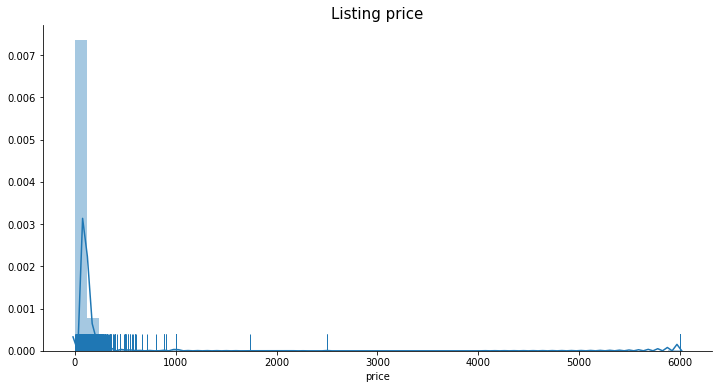

In [3]:
toplist['price'] = toplist['price'].astype(str).str.replace(',', '').astype(str).str.replace('$', '').astype(float) 
print(toplist.price.describe()) # 印出一些價格分布數值 get an intuition of what the data look like
plt.figure(figsize = (12, 6))
plt.title('Listing price', fontsize=15)
sns.distplot(toplist.price.dropna(), rug=True)
sns.despine()

# 去除離群值 
Plot without outliers

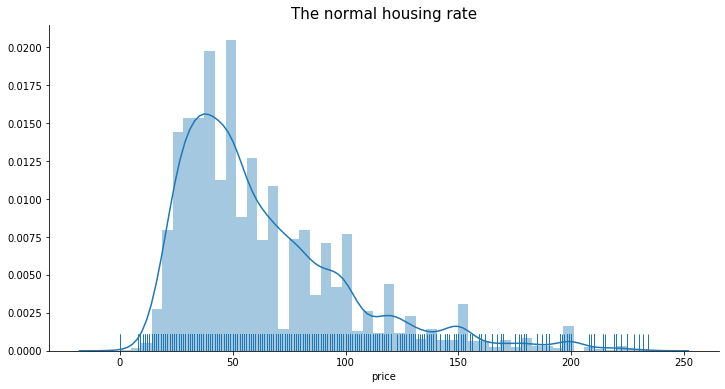

In [4]:
# 去除離群值 plot without outliers
# 只取標準差價格以內的房源 only use the price that's below the std
plt.figure(figsize=(12 , 6))
plt.title('The normal housing rate', fontsize=15)
sns.distplot(toplist[toplist.price<235].price.dropna(), rug=True) 
sns.despine()

# 取標準差以下價位區間的資料 
Plot out the price under std

Text(0.5, 1.0, 'Listings with Acceptable Price')

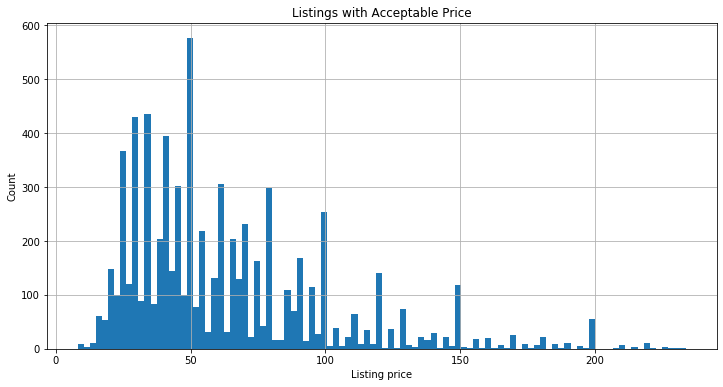

In [5]:
# 取標準差以下價位區間的資料 plot out the price under std
plt.figure(figsize=(12,6))
toplist.loc[(toplist.price<235)&(toplist.price>0)].price.hist(bins=100)
plt.ylabel('Count')
plt.xlabel('Listing price')
plt.title('Listings with Acceptable Price')

# 畫出標準差以下各區域價位區間

Plot out price range of different areas

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

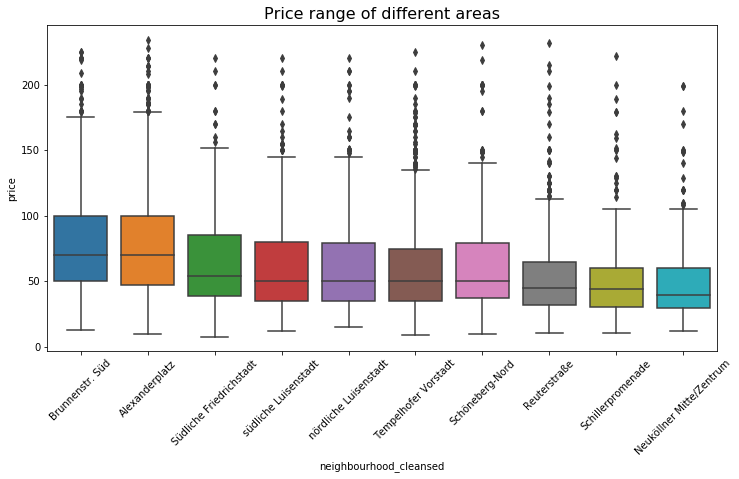

In [6]:
drop_outlier_price_condition = toplist.loc[(toplist.price<=234)&(toplist.price>0)]
sort_price = drop_outlier_price_condition\
        .groupby('neighbourhood_cleansed')['price']\
        .median()\
        .sort_values(ascending=False)\
        .index

plt.figure(figsize=(12,6))   
plt.title('Price range of different areas', fontsize=16)
sns.boxplot(y='price', x='neighbourhood_cleansed', data=drop_outlier_price_condition, order=sort_price)
plt.xticks(rotation=45)


# 不同類型住房對價格的影響
The relation between different property types and price

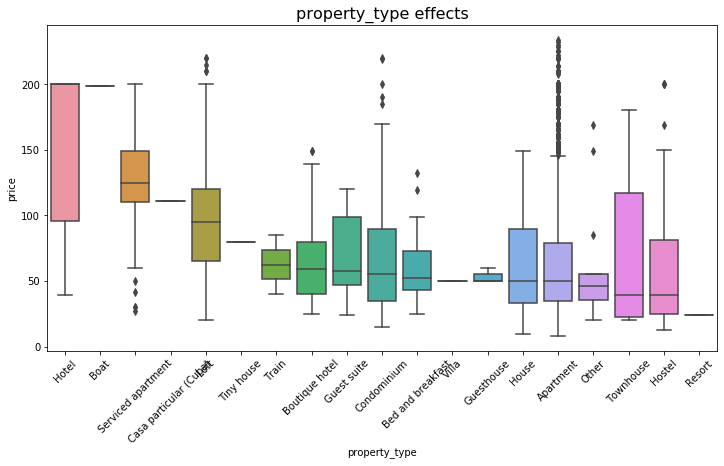

In [7]:
def boxplot_to_price(category_name):
    sort_price = drop_outlier_price_condition\
                .groupby(category_name)['price']\
                .median()\
                .sort_values(ascending=False)\
                .index
    plt.figure(figsize=(12,6))
    plt.title(category_name +' effects', fontsize=16)
    sns.boxplot(y='price', x=category_name, data=drop_outlier_price_condition, order=sort_price)
    plt.xticks(rotation=45)
boxplot_to_price('property_type')

# 住房包含設施數量前20名
The top 20 amenities listings contain

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

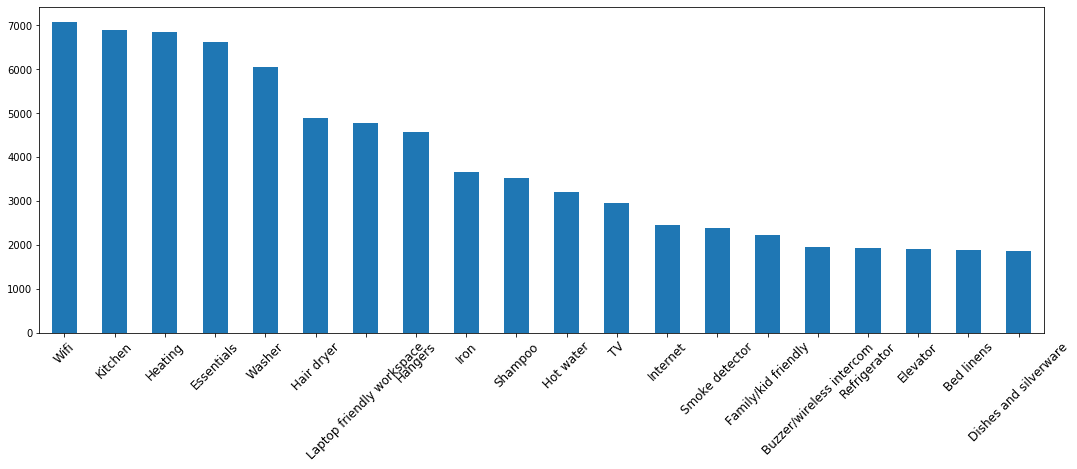

In [8]:
toplist['amenities'] = toplist.amenities.str.replace('[{}]', '').str.replace('"', '')
toplist.amenities.head()
all_item_ls = np.concatenate(toplist.amenities.map(lambda am:am.split(',')))
Top20_item = pd.Series(all_item_ls).value_counts().head(20)
plt.figure(figsize=(18 , 6))
Top20_item.plot(kind='bar')
plt.xticks(rotation=45, fontsize=12)

# 住房包含設施數量後20名
The bottom 20 amenities listings contain

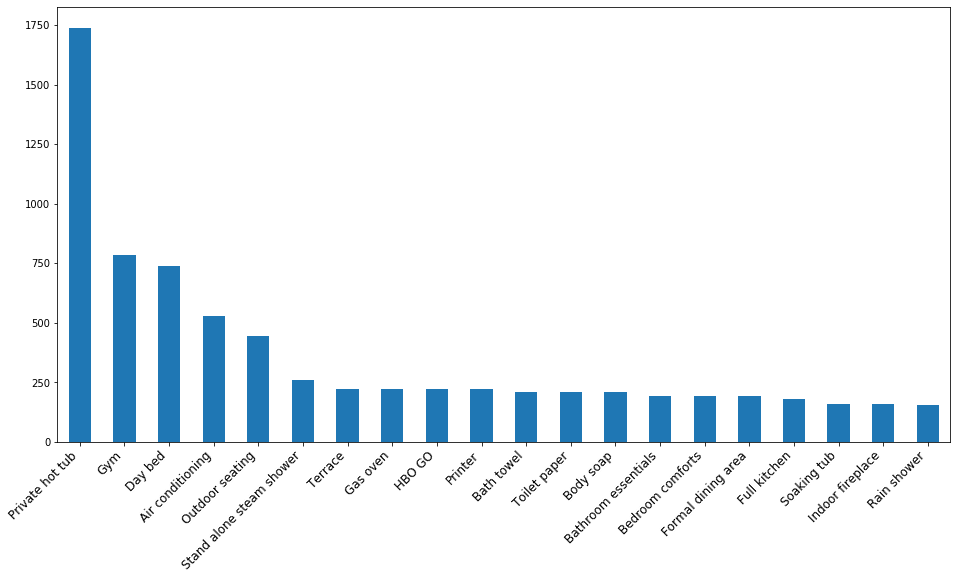

In [9]:
amenities = np.unique(np.concatenate(toplist['amenities'].map(lambda amns: amns.split(","))))
amenity_prices = [(amn, toplist[toplist['amenities'].map(lambda amns: amn in amns)]['price'].mean()) for amn in amenities if amn != ""]
amenity_srs = pd.Series(data=[a[1] for a in amenity_prices], index=[a[0] for a in amenity_prices])
plt.figure(figsize=(16,8))
amenity_srs.sort_values(ascending=False)[:20].plot(kind='bar')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
plt.show()

# 床的數量與價格關係
The relation between nembers of beds and price.

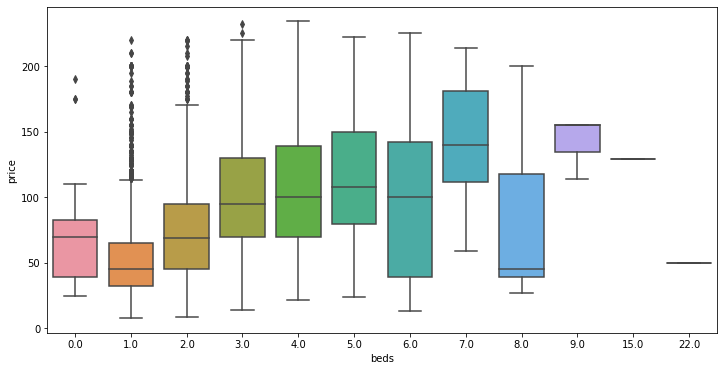

In [10]:
plt.figure(figsize=(12,6))
sns.boxplot(y='price', x='beds', data=drop_outlier_price_condition)
plt.show()

In [11]:
# 只取想要的欄位存成新的檔案明天來看 Save only the columns wanted for tomorrow's analysis
df = drop_outlier_price_condition[['id','name','summary','space','description','host_id','host_name','host_location','host_about','host_is_superhost','neighbourhood_group_cleansed','city','state','zipcode','market','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','square_feet','price']]
df.to_csv('drop.csv')

[Code Reference](https://medium.com/finformation%E7%95%B6%E7%A8%8B%E5%BC%8F%E9%81%87%E4%B8%8A%E8%B2%A1%E5%8B%99%E9%87%91%E8%9E%8D/%E5%88%A9%E7%94%A8airbnb%E4%BE%86%E6%9B%B4%E4%BA%86%E8%A7%A3%E5%B1%85%E4%BD%8F%E5%9F%8E%E5%B8%82-%E4%BB%A5%E8%87%BA%E5%8C%97%E7%82%BA%E4%BE%8B-python%E5%AF%A6%E4%BD%9C-3f4903e8742)

文中若有錯誤還望不吝指正，感激不盡。
Please let me know if there’s any mistake in this article. Thanks for reading.

Reference 參考資料：

[1] [Inside Airbnb](http://insideairbnb.com/get-the-data.html)

[2] [利用Airbnb來更了解居住城市，以臺北為例 Python實作（上）](https://medium.com/finformation%E7%95%B6%E7%A8%8B%E5%BC%8F%E9%81%87%E4%B8%8A%E8%B2%A1%E5%8B%99%E9%87%91%E8%9E%8D/%E5%88%A9%E7%94%A8airbnb%E4%BE%86%E6%9B%B4%E4%BA%86%E8%A7%A3%E5%B1%85%E4%BD%8F%E5%9F%8E%E5%B8%82-%E4%BB%A5%E8%87%BA%E5%8C%97%E7%82%BA%E4%BE%8B-python%E5%AF%A6%E4%BD%9C-3f4903e8742)

[3] [Airbnb listings in Berlin](https://github.com/tgnco1218/Data-Cleaning-and-Scraping-30Days/blob/master/Day19_Airbnb_in_Berlin/Berlin_airbnb.ipynb)
